# Tournament Score Model Model
- The goal of this notebook is to focus on creating the best model to predict the overall score of the tournament for a given player
- Features will be engineered based on analysis from exploratory_v2
- The goal is to pick the model the has the least mean square error

In [27]:
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np

conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Data/PGA_SQL_DB/PGA.db')

## Pull Data from the SQL Database

In [5]:
model_data_query = """WITH TOURNAMENT_AVERAGES AS (
    SELECT TOURNAMENT_NAME,
        AVG(SG_PUTT) AS TOURN_AVG_SG_PUTT,
        AVG(SG_OFF_THE_TEE) AS TOURN_AVG_SG_OFF_THE_TEE,
        AVG(SG_APPROACH) AS TOURN_AVG_SG_APPROACH,
        AVG(SG_AROUND_THE_GREEN) AS TOURN_AVG_SG_AROUND_THE_GREEN,
        AVG(TOTAL_SCORE_TO_PAR) AS TOURN_AVG_TOTAL_SCORE_TO_PAR
    FROM PLAYER_TOURNAMENT_RESULTS_V3
    GROUP BY 1
)

SELECT PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME,
    PAR, LENGTH, ELEVATION,
    R1_TEMP, R1_PRECIP, R1_WIND_SPEED,
    R2_TEMP, R2_PRECIP, R2_WIND_SPEED,
    R3_TEMP, R3_PRECIP, R3_WIND_SPEED,
    R4_TEMP, R4_PRECIP, R4_WIND_SPEED,
    SG_PUTT, TOURN_AVG_SG_PUTT, SG_PUTT - TOURN_AVG_SG_PUTT AS ADJ_SG_PUTT,
    SG_OFF_THE_TEE, TOURN_AVG_SG_OFF_THE_TEE, SG_OFF_THE_TEE - TOURN_AVG_SG_OFF_THE_TEE AS ADJ_SG_OFF_THE_TEE,
    SG_APPROACH, TOURN_AVG_SG_APPROACH, SG_APPROACH - TOURN_AVG_SG_APPROACH AS ADJ_SG_APPROACH,
    SG_AROUND_THE_GREEN, TOURN_AVG_SG_AROUND_THE_GREEN, SG_AROUND_THE_GREEN - TOURN_AVG_SG_AROUND_THE_GREEN AS ADJ_SG_AROUND_THE_GREEN, 
    TOURN_AVG_TOTAL_SCORE_TO_PAR, TOTAL_SCORE_TO_PAR - TOURN_AVG_TOTAL_SCORE_TO_PAR AS ADJ_TOT_SCORE_TO_PAR,
    R1_SCORE - PAR AS R1_SCORE_TO_PAR, R2_SCORE - PAR AS R2_SCORE_TO_PAR, R3_SCORE - PAR AS R3_SCORE_TO_PAR, R4_SCORE - PAR AS R4_SCORE_TO_PAR,
    R1_SCORE, R2_SCORE, R3_SCORE, R4_SCORE, TOTAL_SCORE_TO_PAR
FROM PLAYER_TOURNAMENT_RESULTS_V3
INNER JOIN TOURNAMENT_AVERAGES ON PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME = TOURNAMENT_AVERAGES.TOURNAMENT_NAME
ORDER BY PLAYER_NAME, PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_DATE"""

model_data_df = pd.read_sql_query(model_data_query, conn)
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,ADJ_TOT_SCORE_TO_PAR,R1_SCORE_TO_PAR,R2_SCORE_TO_PAR,R3_SCORE_TO_PAR,R4_SCORE_TO_PAR,R1_SCORE,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,72,7189,6.0,78.9,0.000,9.1,79.1,...,1.394366,-2,1,4,0,70,73,76,72,3
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,94.0,59.1,0.000,10.3,63.8,...,-0.750000,-3,-4,2,1,69,68,74,73,-4
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,201.0,70.8,0.000,18.3,66.6,...,-3.661972,-1,-1,-4,-1,71,71,68,71,-7
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,11.0,66.1,0.004,21.4,62.1,...,-0.500000,4,2,7,-1,74,72,77,69,12
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,106.0,53.7,1.602,17.5,51.1,...,2.236111,-2,0,0,2,69,71,71,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,183.0,78.1,0.000,10.1,81.8,...,8.347826,-3,-3,2,1,69,69,74,73,-3
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,72,7435,201.0,70.8,0.000,18.3,66.6,...,3.338028,-1,-1,1,1,71,71,73,73,0
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,21.0,72.2,0.000,10.7,69.6,...,14.074627,-3,2,6,8,67,72,76,78,13
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,16.0,61.2,0.000,12.7,67.8,...,7.388889,0,-2,1,9,71,69,72,80,8


## Compute Features

### Weather Factor

In [6]:
def weather_weighted_average(temp, precip, wind_speed, elevation):
    weights = [0.1, 0.4, 0.2, 0.3]
    return (temp * -1 * weights[0] + elevation * -1 *weights[1] + precip * weights[2] + wind_speed * weights[3]) / (weights[0] + weights[1] + weights[2] + weights[3])

scaler = StandardScaler()
model_data_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED',
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'ELEVATION']] = scaler.fit_transform(model_data_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'ELEVATION']])

model_data_df['R1_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R1_TEMP'], row['R1_PRECIP'], row['R1_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df['R2_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R2_TEMP'], row['R2_PRECIP'], row['R2_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df['R3_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R3_TEMP'], row['R3_PRECIP'], row['R3_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df['R4_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R4_TEMP'], row['R4_PRECIP'], row['R4_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,R4_SCORE_TO_PAR,R1_SCORE,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,72,7189,-0.928824,1.477375,-0.338412,-0.605286,1.538345,...,0,70,73,76,72,3,-0.025476,0.317306,0.981257,0.606651
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,-0.342815,-1.168057,-0.338412,-0.335730,-0.685256,...,1,69,68,74,73,-4,0.085530,0.196198,1.080353,-0.122401
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,-1,71,71,68,71,-7,0.183307,0.113740,0.072822,-0.018527
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,-1,74,72,77,69,12,0.964256,0.607373,0.662442,0.606665
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,2,69,71,71,73,0,1.872416,0.220411,0.143113,0.525471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,0.249853,1.370488,-0.338412,-0.380656,1.930746,...,1,69,69,74,73,-3,-0.418869,-0.677962,-0.332181,-0.451462
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,1,71,71,73,73,0,0.183307,0.113740,0.072822,-0.018527
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,-0.828936,0.582203,-0.338412,-0.245879,0.157678,...,8,67,72,76,78,13,0.131908,0.370877,1.388025,0.337408
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,-0.862232,-0.887481,-0.338412,0.203381,-0.103922,...,9,71,69,72,80,8,0.426973,0.611445,0.741818,1.297037


### Historical Aggregation of Adjusted Player Statistics

In [7]:
def convert_string_to_date(date_string):
    return datetime.strptime(date_string, "%Y-%m-%d")

def compute_days_between(date_one, date_two):
    duration = date_two - date_one
    return duration.days

def compute_half_life_weight(half_life, days):
    return np.power(0.5, (days / half_life))

# for each row, need to look at all previous tournaments for that player. and calculate weights based on the different between that rows tournament date and the other rows tournament weight.
def calc_weighted_avgs(df, player_name, tournament_date, features):
    prev_rounds_df = df.copy()
    tournament_date = convert_string_to_date(tournament_date)
    prev_rounds_df.loc[:, 'TOURNAMENT_DATE'] = prev_rounds_df.apply(lambda row: convert_string_to_date(row['TOURNAMENT_DATE']), axis=1)
    prev_rounds_df = prev_rounds_df.loc[(prev_rounds_df['PLAYER_NAME'] == player_name) & (prev_rounds_df['TOURNAMENT_DATE'] < tournament_date)].sort_values(by='TOURNAMENT_DATE', ascending=False)

    if prev_rounds_df.shape[0] == 0:
        return None

    # Retrieve the 3 most recent tournaments
    prev_3_rounds_df = prev_rounds_df.head(3)

    # Weighting by how recent data is
    prev_rounds_df['DAYS_SINCE'] = prev_rounds_df.apply(lambda row: compute_days_between(row['TOURNAMENT_DATE'], tournament_date), axis=1)
    prev_rounds_df['HL_50_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(50, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_100_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(100, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_200_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(200, row['DAYS_SINCE']), axis=1)

    weight_sum_HL_50 = prev_rounds_df['HL_50_WEIGHT'].sum()
    weight_sum_HL_100 = prev_rounds_df['HL_100_WEIGHT'].sum()
    weight_sum_HL_200 = prev_rounds_df['HL_200_WEIGHT'].sum()
    
    # SG_PUTT
    PREV_SG_P = prev_rounds_df[features[0]].iloc[0]
    PREV_3_AVG_SG_P = prev_3_rounds_df[features[0]].mean()

    prev_rounds_df['HL_50_SG_P'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[0]]
    prev_rounds_df['HL_100_SG_P'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[0]]
    prev_rounds_df['HL_200_SG_P'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[0]]

    HL_50_SG_P = prev_rounds_df['HL_50_SG_P'].sum() / weight_sum_HL_50
    HL_100_SG_P = prev_rounds_df['HL_100_SG_P'].sum() / weight_sum_HL_100
    HL_200_SG_P = prev_rounds_df['HL_200_SG_P'].sum() / weight_sum_HL_200

    # SG_OFF_THE_TEE
    PREV_SG_OTT = prev_rounds_df[features[1]].iloc[0]
    PREV_3_AVG_SG_OTT = prev_3_rounds_df[features[1]].mean()

    prev_rounds_df['HL_50_SG_OTT'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[1]]
    prev_rounds_df['HL_100_SG_OTT'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[1]]
    prev_rounds_df['HL_200_SG_OTT'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[1]]

    HL_50_SG_OTT = prev_rounds_df['HL_50_SG_OTT'].sum() / weight_sum_HL_50
    HL_100_SG_OTT = prev_rounds_df['HL_100_SG_OTT'].sum() / weight_sum_HL_100
    HL_200_SG_OTT = prev_rounds_df['HL_200_SG_OTT'].sum() / weight_sum_HL_200

    # SG_APPROACH
    PREV_SG_APR = prev_rounds_df[features[2]].iloc[0]
    PREV_3_AVG_SG_APR = prev_3_rounds_df[features[2]].mean()

    prev_rounds_df['HL_50_SG_APR'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[2]]
    prev_rounds_df['HL_100_SG_APR'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[2]]
    prev_rounds_df['HL_200_SG_APR'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[2]]

    HL_50_SG_APR = prev_rounds_df['HL_50_SG_APR'].sum() / weight_sum_HL_50
    HL_100_SG_APR = prev_rounds_df['HL_100_SG_APR'].sum() / weight_sum_HL_100
    HL_200_SG_APR = prev_rounds_df['HL_200_SG_APR'].sum() / weight_sum_HL_200

    # SG_AROUND_THE_GREEN
    PREV_SG_ATG = prev_rounds_df[features[3]].iloc[0]
    PREV_3_AVG_SG_ATG = prev_3_rounds_df[features[3]].mean()

    prev_rounds_df['HL_50_SG_ATG'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[3]]
    prev_rounds_df['HL_100_SG_ATG'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[3]]
    prev_rounds_df['HL_200_SG_ATG'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[3]]

    HL_50_SG_ATG = prev_rounds_df['HL_50_SG_ATG'].sum() / weight_sum_HL_50
    HL_100_SG_ATG = prev_rounds_df['HL_100_SG_ATG'].sum() / weight_sum_HL_100
    HL_200_SG_ATG = prev_rounds_df['HL_200_SG_ATG'].sum() / weight_sum_HL_200

    # TOTAL_SCORE_TO_PAR
    PREV_TOT_SCORE_TO_PAR = prev_rounds_df[features[4]].iloc[0]
    PREV_3_AVG_TOT_SCORE_TO_PAR = prev_3_rounds_df[features[4]].mean()

    prev_rounds_df['HL_50_TOT_SCORE_TO_PAR'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[4]]
    prev_rounds_df['HL_100_TOT_SCORE_TO_PAR'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[4]]
    prev_rounds_df['HL_200_TOT_SCORE_TO_PAR'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[4]]

    HL_50_TOT_SCORE_TO_PAR = prev_rounds_df['HL_50_TOT_SCORE_TO_PAR'].sum() / weight_sum_HL_50
    HL_100_TOT_SCORE_TO_PAR = prev_rounds_df['HL_100_TOT_SCORE_TO_PAR'].sum() / weight_sum_HL_100
    HL_200_TOT_SCORE_TO_PAR = prev_rounds_df['HL_200_TOT_SCORE_TO_PAR'].sum() / weight_sum_HL_200

    return PREV_SG_P, PREV_3_AVG_SG_P, HL_50_SG_P, HL_100_SG_P, HL_200_SG_P, PREV_SG_OTT, PREV_3_AVG_SG_OTT, HL_50_SG_OTT, HL_100_SG_OTT, HL_200_SG_OTT, PREV_SG_APR, PREV_3_AVG_SG_APR, HL_50_SG_APR, HL_100_SG_APR, HL_200_SG_APR, PREV_SG_ATG, PREV_3_AVG_SG_ATG, HL_50_SG_ATG, HL_100_SG_ATG, HL_200_SG_ATG, PREV_TOT_SCORE_TO_PAR, PREV_3_AVG_TOT_SCORE_TO_PAR, HL_50_TOT_SCORE_TO_PAR, HL_100_TOT_SCORE_TO_PAR, HL_200_TOT_SCORE_TO_PAR

# Apply the relevant half life values for each of the factors based on the half-life values from the research paper
model_data_df[['PREV_SG_P', 'PREV_3_AVG_SG_P', 'HL_50_SG_P', 'HL_100_SG_P', 'HL_200_SG_P', 
    'PREV_SG_OTT', 'PREV_3_AVG_SG_OTT', 'HL_50_SG_OTT', 'HL_100_SG_OTT', 'HL_200_SG_OTT',
    'PREV_SG_APR', 'PREV_3_AVG_SG_APR', 'HL_50_SG_APR', 'HL_100_SG_APR', 'HL_200_SG_APR',
    'PREV_SG_ATG', 'PREV_3_AVG_SG_ATG', 'HL_50_SG_ATG', 'HL_100_SG_ATG', 'HL_200_SG_ATG',
    'PREV_TOT_SCORE_TO_PAR', 'PREV_3_AVG_TOT_SCORE_TO_PAR', 'HL_50_TOT_SCORE_TO_PAR', 'HL_100_TOT_SCORE_TO_PAR', 'HL_200_TOT_SCORE_TO_PAR']] = model_data_df.apply(
        lambda row: pd.Series(calc_weighted_avgs(model_data_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], ["ADJ_SG_PUTT", "ADJ_SG_OFF_THE_TEE", "ADJ_SG_APPROACH", "ADJ_SG_AROUND_THE_GREEN", "ADJ_TOT_SCORE_TO_PAR"])), axis=1)
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,72,7189,-0.928824,1.477375,-0.338412,-0.605286,1.538345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,-0.342815,-1.168057,-0.338412,-0.335730,-0.685256,...,-0.210268,-0.210268,-0.210268,-0.210268,-0.210268,1.394366,1.394366,1.394366,1.394366,1.394366
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,0.241306,0.015519,0.201228,0.133898,0.079454,-0.750000,0.322183,-0.559684,-0.239956,0.018576
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,0.957887,0.329642,0.890983,0.726660,0.554320,-3.661972,-1.005869,-3.387666,-2.701688,-1.971064
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,-0.288758,0.303478,0.106957,0.204029,0.220233,-0.500000,-1.637324,-1.468596,-1.568490,-1.388124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,0.249853,1.370488,-0.338412,-0.380656,1.930746,...,0.071125,-0.193099,-0.095396,-0.142453,-0.167539,4.472222,2.785407,3.409149,3.108737,2.948585
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,-0.828936,0.582203,-0.338412,-0.245879,0.157678,...,-0.202113,-0.202113,-0.202113,-0.202113,-0.202113,3.338028,3.338028,3.338028,3.338028,3.338028
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,-0.862232,-0.887481,-0.338412,0.203381,-0.103922,...,0.029896,-0.086109,0.029896,0.029893,0.029177,14.074627,8.706328,14.074627,14.074523,14.041366


In [8]:
model_data_df.to_csv('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Model Development/model_data.csv', index=False)

In [38]:
model_data_df = pd.read_csv('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Model Development/model_data.csv')
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,72,7189,-0.928824,1.477375,-0.338412,-0.605286,1.538345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,-0.342815,-1.168057,-0.338412,-0.335730,-0.685256,...,-0.210268,-0.210268,-0.210268,-0.210268,-0.210268,1.394366,1.394366,1.394366,1.394366,1.394366
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,0.241306,0.015519,0.201228,0.133898,0.079454,-0.750000,0.322183,-0.559684,-0.239956,0.018576
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,0.957887,0.329642,0.890983,0.726660,0.554320,-3.661972,-1.005869,-3.387666,-2.701688,-1.971064
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,-0.288758,0.303478,0.106957,0.204029,0.220233,-0.500000,-1.637324,-1.468596,-1.568490,-1.388124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,0.249853,1.370488,-0.338412,-0.380656,1.930746,...,0.071125,-0.193099,-0.095396,-0.142453,-0.167539,4.472222,2.785407,3.409149,3.108737,2.948585
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,-0.828936,0.582203,-0.338412,-0.245879,0.157678,...,-0.202113,-0.202113,-0.202113,-0.202113,-0.202113,3.338028,3.338028,3.338028,3.338028,3.338028
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,-0.862232,-0.887481,-0.338412,0.203381,-0.103922,...,0.029896,-0.086109,0.029896,0.029893,0.029177,14.074627,8.706328,14.074627,14.074523,14.041366


In [39]:
model_data_df = model_data_df.dropna()
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,-0.342815,-1.168057,-0.338412,-0.335730,-0.685256,...,-0.210268,-0.210268,-0.210268,-0.210268,-0.210268,1.394366,1.394366,1.394366,1.394366,1.394366
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,0.241306,0.015519,0.201228,0.133898,0.079454,-0.750000,0.322183,-0.559684,-0.239956,0.018576
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,0.957887,0.329642,0.890983,0.726660,0.554320,-3.661972,-1.005869,-3.387666,-2.701688,-1.971064
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,-0.288758,0.303478,0.106957,0.204029,0.220233,-0.500000,-1.637324,-1.468596,-1.568490,-1.388124
5,2020 Waste Management Phoenix Open,2020-01-30,Aaron Baddeley,71,7261,1.608329,-1.782652,-0.338412,-0.380656,-1.818856,...,0.368389,0.345840,0.355846,0.325277,0.291477,2.236111,-0.641954,2.058361,1.238151,0.354667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,2019 3M Open,2019-07-04,Zack Sucher,71,7468,0.862499,1.009748,1.519980,-0.807452,0.680878,...,-0.457324,-0.457324,-0.457324,-0.457324,-0.457324,1.098592,1.098592,1.098592,1.098592,1.098592
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,0.249853,1.370488,-0.338412,-0.380656,1.930746,...,0.071125,-0.193099,-0.095396,-0.142453,-0.167539,4.472222,2.785407,3.409149,3.108737,2.948585
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,-0.828936,0.582203,-0.338412,-0.245879,0.157678,...,-0.202113,-0.202113,-0.202113,-0.202113,-0.202113,3.338028,3.338028,3.338028,3.338028,3.338028
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,-0.862232,-0.887481,-0.338412,0.203381,-0.103922,...,0.029896,-0.086109,0.029896,0.029893,0.029177,14.074627,8.706328,14.074627,14.074523,14.041366


## Pull Features and Save Off a Tournament for Validation

In [40]:
model_data_df.columns

Index(['TOURNAMENT_NAME', 'TOURNAMENT_DATE', 'PLAYER_NAME', 'PAR', 'LENGTH',
       'ELEVATION', 'R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R2_TEMP',
       'R2_PRECIP', 'R2_WIND_SPEED', 'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED',
       'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'SG_PUTT', 'TOURN_AVG_SG_PUTT',
       'ADJ_SG_PUTT', 'SG_OFF_THE_TEE', 'TOURN_AVG_SG_OFF_THE_TEE',
       'ADJ_SG_OFF_THE_TEE', 'SG_APPROACH', 'TOURN_AVG_SG_APPROACH',
       'ADJ_SG_APPROACH', 'SG_AROUND_THE_GREEN',
       'TOURN_AVG_SG_AROUND_THE_GREEN', 'ADJ_SG_AROUND_THE_GREEN',
       'TOURN_AVG_TOTAL_SCORE_TO_PAR', 'ADJ_TOT_SCORE_TO_PAR',
       'R1_SCORE_TO_PAR', 'R2_SCORE_TO_PAR', 'R3_SCORE_TO_PAR',
       'R4_SCORE_TO_PAR', 'R1_SCORE', 'R2_SCORE', 'R3_SCORE', 'R4_SCORE',
       'TOTAL_SCORE_TO_PAR', 'R1_WEATHER_FACTOR', 'R2_WEATHER_FACTOR',
       'R3_WEATHER_FACTOR', 'R4_WEATHER_FACTOR', 'PREV_SG_P',
       'PREV_3_AVG_SG_P', 'HL_50_SG_P', 'HL_100_SG_P', 'HL_200_SG_P',
       'PREV_SG_OTT', 'PREV_3_AVG_SG

In [41]:
# Saving off most recent Tournament to use to validate after model is built to see how it would do in "Production"
validation_tournament_df = model_data_df.loc[model_data_df['TOURNAMENT_NAME'] == '2024 ZOZO CHAMPIONSHIP']
validation_tournament_df = validation_tournament_df.sort_values(by='R1_SCORE_TO_PAR')
validation_tournament_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
4699,2024 ZOZO CHAMPIONSHIP,2024-10-24,Taylor Moore,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,0.036053,-0.017177,-0.093580,-0.100784,-0.110110,-4.539474,-1.257503,-1.295197,-1.208133,-1.398119
3503,2024 ZOZO CHAMPIONSHIP,2024-10-24,Nico Echavarria,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,0.103274,-0.467724,-0.385191,-0.426240,-0.446955,4.027397,3.603976,3.665178,3.634739,3.619378
1667,2024 ZOZO CHAMPIONSHIP,2024-10-24,Eric Cole,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,0.899274,0.093891,0.391553,0.287113,0.266897,-7.972603,1.479435,-0.971528,-0.041167,-0.298497
3327,2024 ZOZO CHAMPIONSHIP,2024-10-24,Max Greyserman,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,-0.576726,-0.132224,-0.196473,-0.164518,-0.148393,-1.972603,-1.896024,-1.907092,-1.901587,-1.898809
2808,2024 ZOZO CHAMPIONSHIP,2024-10-24,Kevin Yu,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,-0.169726,-0.342222,-0.175561,-0.244187,-0.289718,-3.972603,-0.513106,-1.322533,-0.902631,-0.701427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,2024 ZOZO CHAMPIONSHIP,2024-10-24,Satoshi Kodaira,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,0.209566,-0.273049,0.209551,0.205520,0.136768,0.421687,-1.642392,0.421596,0.399904,0.143458
2504,2024 ZOZO CHAMPIONSHIP,2024-10-24,Justin Lower,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,-0.055726,-0.044438,-0.026345,-0.046066,-0.088324,7.027397,2.439236,3.972802,3.096741,2.474345
1473,2024 ZOZO CHAMPIONSHIP,2024-10-24,Davis Riley,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,-0.229104,-0.051534,-0.185549,-0.175382,-0.177570,-0.626866,1.103482,-0.096328,0.206385,0.264831
652,2024 ZOZO CHAMPIONSHIP,2024-10-24,Brendon Todd,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,0.365274,0.534868,0.500816,0.508107,0.498855,-6.972603,5.556160,2.622872,2.974757,2.723431


In [42]:
model_data_df = model_data_df.loc[model_data_df['TOURNAMENT_NAME'] != '2024 ZOZO CHAMPIONSHIP']
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,-0.342815,-1.168057,-0.338412,-0.335730,-0.685256,...,-0.210268,-0.210268,-0.210268,-0.210268,-0.210268,1.394366,1.394366,1.394366,1.394366,1.394366
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,0.241306,0.015519,0.201228,0.133898,0.079454,-0.750000,0.322183,-0.559684,-0.239956,0.018576
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,0.957887,0.329642,0.890983,0.726660,0.554320,-3.661972,-1.005869,-3.387666,-2.701688,-1.971064
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,-0.288758,0.303478,0.106957,0.204029,0.220233,-0.500000,-1.637324,-1.468596,-1.568490,-1.388124
5,2020 Waste Management Phoenix Open,2020-01-30,Aaron Baddeley,71,7261,1.608329,-1.782652,-0.338412,-0.380656,-1.818856,...,0.368389,0.345840,0.355846,0.325277,0.291477,2.236111,-0.641954,2.058361,1.238151,0.354667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,2019 3M Open,2019-07-04,Zack Sucher,71,7468,0.862499,1.009748,1.519980,-0.807452,0.680878,...,-0.457324,-0.457324,-0.457324,-0.457324,-0.457324,1.098592,1.098592,1.098592,1.098592,1.098592
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,0.249853,1.370488,-0.338412,-0.380656,1.930746,...,0.071125,-0.193099,-0.095396,-0.142453,-0.167539,4.472222,2.785407,3.409149,3.108737,2.948585
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,-0.828936,0.582203,-0.338412,-0.245879,0.157678,...,-0.202113,-0.202113,-0.202113,-0.202113,-0.202113,3.338028,3.338028,3.338028,3.338028,3.338028
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,-0.862232,-0.887481,-0.338412,0.203381,-0.103922,...,0.029896,-0.086109,0.029896,0.029893,0.029177,14.074627,8.706328,14.074627,14.074523,14.041366


## Feature Selection for each Historical Player Statistic

### Strokes Gained Putting

In [74]:
features = {'SG_P': ['PREV_SG_P', 'PREV_3_AVG_SG_P', 'HL_50_SG_P', 'HL_100_SG_P', 'HL_200_SG_P'],
            'SG_OTT': ['PREV_SG_OTT', 'PREV_3_AVG_SG_OTT', 'HL_50_SG_OTT', 'HL_100_SG_OTT', 'HL_200_SG_OTT'],
            'SG_APR': ['PREV_SG_APR', 'PREV_3_AVG_SG_APR', 'HL_50_SG_APR', 'HL_100_SG_APR', 'HL_200_SG_APR'],
            'SG_ATG': ['PREV_SG_ATG', 'PREV_3_AVG_SG_ATG', 'HL_50_SG_ATG', 'HL_100_SG_ATG', 'HL_200_SG_ATG'],
            'SG_SCORE_TO_PAR': ['PREV_TOT_SCORE_TO_PAR', 'PREV_3_AVG_TOT_SCORE_TO_PAR', 'HL_50_TOT_SCORE_TO_PAR', 'HL_100_TOT_SCORE_TO_PAR', 'HL_200_TOT_SCORE_TO_PAR']}
target = 'R1_SCORE_TO_PAR'

#### Decision Tree for Feature Importance

In [87]:
for key in features:
    print(key)
    kf = KFold(n_splits=5, shuffle=True)
    decision_tree = DecisionTreeClassifier()

    param_grid = {
        'max_depth': [2,3,4,5],
        'min_samples_split': [3,5,7,9]
    }

    cv = GridSearchCV(estimator=decision_tree, param_grid=param_grid, 
        scoring='neg_mean_squared_error', cv=kf, n_jobs=-1, return_train_score=True)
    cv.fit(model_data_df[features[key]], model_data_df[target])

    # Convert results into a DataFrame
    cv_results = pd.DataFrame(cv.cv_results_)

    # Get best model index
    best_xgb_index = cv.best_index_
    best_xgb_model = cv.best_estimator_

    # Retrieve Training and Testing MSE
    train_mse = -cv_results.loc[best_xgb_index, 'mean_train_score']
    test_mse = -cv_results.loc[best_xgb_index, 'mean_test_score']
    params = cv_results.loc[best_xgb_index, 'params']

    # Retrieve Feature Importance
    feature_importance = best_xgb_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features[key], 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("Best Hyperparameters:", params)
    print("Feature Importance", importance_df)
    print("Training MSE:", train_mse)
    print("Testing MSE:", test_mse)

SG_P
Best Hyperparameters: {'max_depth': 3, 'min_samples_split': 3}
Feature Importance            Feature  Importance
0        PREV_SG_P    0.304636
4      HL_200_SG_P    0.279952
2       HL_50_SG_P    0.147702
3      HL_100_SG_P    0.134934
1  PREV_3_AVG_SG_P    0.132776
Training MSE: 7.963359319131589
Testing MSE: 8.023479529602671
SG_OTT
Best Hyperparameters: {'max_depth': 3, 'min_samples_split': 9}
Feature Importance              Feature  Importance
3      HL_100_SG_OTT    0.377605
1  PREV_3_AVG_SG_OTT    0.335711
0        PREV_SG_OTT    0.151683
4      HL_200_SG_OTT    0.135002
2       HL_50_SG_OTT    0.000000
Training MSE: 8.0249556219491
Testing MSE: 8.06169193677019
SG_APR
Best Hyperparameters: {'max_depth': 2, 'min_samples_split': 3}
Feature Importance              Feature  Importance
1  PREV_3_AVG_SG_APR    0.366885
3      HL_100_SG_APR    0.321329
0        PREV_SG_APR    0.311785
2       HL_50_SG_APR    0.000000
4      HL_200_SG_APR    0.000000
Training MSE: 7.98851430404046

- PREV_SG_P, HL_200_SG_P, HL_100_SG_OTT, PREV_3_AVG_SG_OTT, PREV_3_AVG_SG_APR, HL_100_SG_APR, PREV_SG_APR, HL_100_SG_ATG, HL_50_SG_ATG, HL_200_SG_ATG, PREV_3_AVG_TOT_SCORE_TO_PAR, HL_100_TOT_SCORE_TO_PAR

## Compute Correlation Matrix Between Features and Target

In [99]:
features = [
    'PAR', 'LENGTH', 'R1_WEATHER_FACTOR',
    'PREV_SG_P',
    'HL_100_SG_OTT',
    'HL_100_SG_APR', 
    'HL_100_SG_ATG']
target = 'R1_SCORE_TO_PAR'

features_and_targets = features.copy()
features_and_targets.append(target)

print(features_and_targets)

['PAR', 'LENGTH', 'R1_WEATHER_FACTOR', 'PREV_SG_P', 'HL_100_SG_OTT', 'HL_100_SG_APR', 'HL_100_SG_ATG', 'R1_SCORE_TO_PAR']


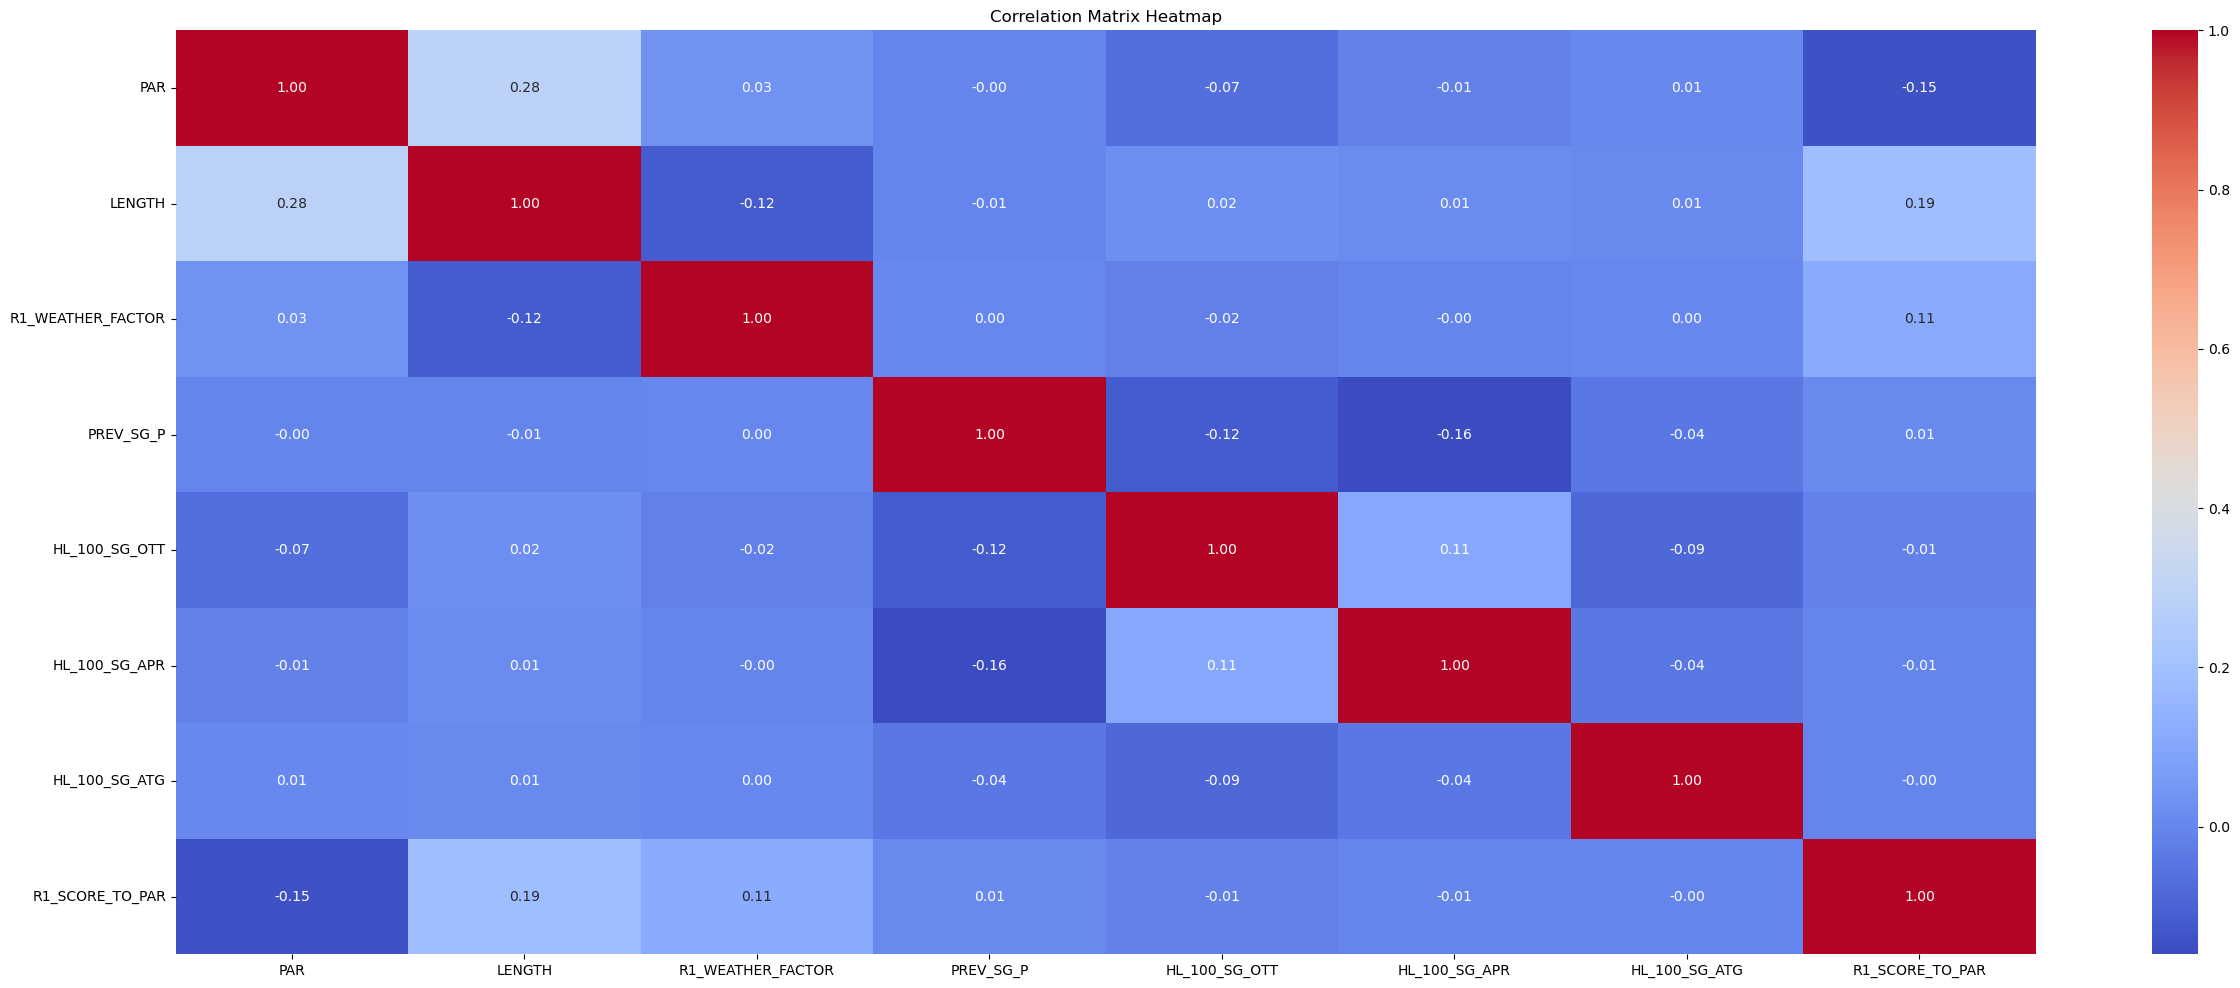

In [100]:
# Compute correlation matrix
correlation_matrix = model_data_df[features_and_targets].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

## Lasso Regression for Feature Selection

In [101]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

lasso_cv = GridSearchCV(Lasso(), {'alpha': alphas}, cv=5)
lasso_cv.fit(model_data_df[features], model_data_df[target])

print("Best alpha for Lasso:", lasso_cv.best_params_['alpha'])

# Display feature importance
lasso_importance = np.abs(lasso_cv.best_estimator_.coef_)
lasso_features = pd.DataFrame({'Feature': features, 'Importance': lasso_importance})
lasso_features = lasso_features.sort_values(by='Importance', ascending=False)
print()
print("Lasso Feature Importance:")
print(lasso_features)

Best alpha for Lasso: 0.01

Lasso Feature Importance:
             Feature  Importance
0                PAR    0.738038
2  R1_WEATHER_FACTOR    0.700028
4      HL_100_SG_OTT    0.144422
5      HL_100_SG_APR    0.013651
3          PREV_SG_P    0.005095
1             LENGTH    0.004075
6      HL_100_SG_ATG    0.000000


## Build XGBoost Model to Predict R1_SCORE_TO_PAR

In [108]:
kf = KFold(n_splits=5, shuffle=True)
xgb_model = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.025, 0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4, 5, 6],
    'n_estimators': [50, 70, 100, 120],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb_cv = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
    scoring='neg_mean_squared_error', cv=kf, n_jobs=-1, return_train_score=True)
xgb_cv.fit(model_data_df[features], model_data_df[target])

# Convert results into a DataFrame
cv_results = pd.DataFrame(xgb_cv.cv_results_)

# Get best model index
best_xgb_index = xgb_cv.best_index_
best_xgb_model = xgb_cv.best_estimator_

# Retrieve Training and Testing MSE
train_mse = -cv_results.loc[best_xgb_index, 'mean_train_score']
test_mse = -cv_results.loc[best_xgb_index, 'mean_test_score']
params = cv_results.loc[best_xgb_index, 'params']

# Retrieve Feature Importance
feature_importance = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Best Hyperparameters:", params)
print("Feature Importance", importance_df)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.9}
Feature Importance              Feature  Importance
0                PAR    0.279128
1             LENGTH    0.261850
2  R1_WEATHER_FACTOR    0.222819
5      HL_100_SG_APR    0.065622
6      HL_100_SG_ATG    0.059455
3          PREV_SG_P    0.056353
4      HL_100_SG_OTT    0.054773
Training MSE: 4.347493466744087
Testing MSE: 5.648823852084732


/Users/nickospelt/anaconda3/envs/pga_model/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Analyze Results on Validation Set

In [109]:
pred_y = best_xgb_model.predict(validation_tournament_df[features])

mae = mean_absolute_error(validation_tournament_df[target], pred_y)
mse = mean_squared_error(validation_tournament_df[target], pred_y)

print(f"Validation Tournament Results - MAE: [{mae}], MSE: [{mse}]")

Validation Tournament Results - MAE: [2.2193203270435333], MSE: [7.842022767617432]
